## **Parallel node execution**

In [4]:
import warnings
warnings.filterwarnings("ignore")

from typing import TypedDict, Annotated
import operator
from langgraph.graph import StateGraph, END
from IPython.display import display, Image

### **Fan in and fan out**

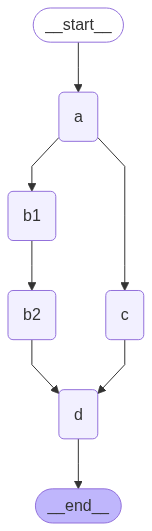

In [11]:
class State(TypedDict):
    messages: Annotated[list, operator.add]


class ReturnNodeMessage:
    def __init__ (self, letter: str):
        self.message = letter
    
    def __call__ (self, state):
        print (f"Adding {self.message} to {state['messages']}")
        return {"messages": [self.message]}
    

builder = StateGraph(State)
builder.add_node("a", ReturnNodeMessage('a'))
builder.add_node("b1", ReturnNodeMessage('b1'))
builder.add_node("b2", ReturnNodeMessage('b2'))
builder.add_node("c", ReturnNodeMessage('c'))
builder.add_node("d", ReturnNodeMessage('d'))

builder.set_entry_point("a")
builder.add_edge("a", "b1")
builder.add_edge("b1", "b2")
builder.add_edge("a", "c")
builder.add_edge("b2", "d")
builder.add_edge("c", "d")
builder.add_edge("d", END)


graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [12]:
graph.invoke({'state': []})

Adding a to []
Adding b1 to ['a']
Adding c to ['a']
Adding b2 to ['a', 'b1', 'c']
Adding d to ['a', 'b1', 'c']
Adding d to ['a', 'b1', 'c', 'b2', 'd']


{'messages': ['a', 'b1', 'c', 'b2', 'd', 'd']}

### **Setting the order of state updates**
It is a deterministic order determined by LangGraph based upon graph topology that **we do not control**. 

Above, we see that `c` is added before `b2`. We can use a custom reducer to customize this e.g., sort state updates.

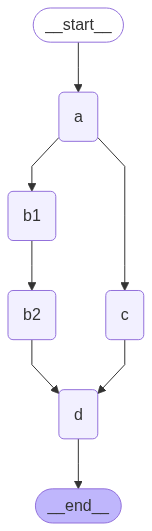

In [16]:
def sorting_reducer(left, right):
    if not isinstance(left, list):
        left = [left]

    if not isinstance(right, list):
        right = [right]
    
    return sorted(left + right, reverse = False)


class State(TypedDict):
    messages: Annotated[list, sorting_reducer]


builder = StateGraph(State)
builder.add_node("a", ReturnNodeMessage('a'))
builder.add_node("b1", ReturnNodeMessage('b1'))
builder.add_node("b2", ReturnNodeMessage('b2'))
builder.add_node("c", ReturnNodeMessage('c'))
builder.add_node("d", ReturnNodeMessage('d'))

builder.set_entry_point("a")
builder.add_edge("a", "b1")
builder.add_edge("b1", "b2")
builder.add_edge("a", "c")
builder.add_edge("b2", "d")
builder.add_edge("c", "d")
builder.add_edge("d", END)


graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [17]:
graph.invoke({'messages': []})

Adding a to []
Adding b1 to ['a']
Adding c to ['a']
Adding b2 to ['a', 'b1', 'c']
Adding d to ['a', 'b1', 'c']
Adding d to ['a', 'b1', 'b2', 'c', 'd']


{'messages': ['a', 'b1', 'b2', 'c', 'd', 'd']}

## **Sub-graphs**
![subgraph.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbb1abf89f2d847ee6f1ff_sub-graph1.png)

In [ ]:
import warnings
warnings.filterwarnings("ignore")

from typing import TypedDict, Optional, List
from langgraph.graph import StateGraph
import operator
from IPython.display import Image, display

### **Input**

In [ ]:
class Log(TypedDict):
    id: str
    question: str
    docs: Optional[List]
    answer: str
    grade: Optional[int]
    grader: Optional[str]
    feedback: Optional[str]

### **Sub graphs**

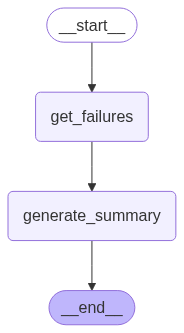

In [38]:
class FailureAnalysisState(TypedDict):
    cleaned_logs: List[Log]
    failures: List[Log]
    fa_summary: str
    processed_logs: List[str]

class FailureAnalysisOutputState(TypedDict):
    fa_summary: str
    processed_logs: List[str]


def get_failures(state):
    cleaned_logs = state["cleaned_logs"]
    failures = [log for log in cleaned_logs if "grade" in log]
    return {"failures": failures}

def generate_summary(state):
    failures = state["failures"]
    fa_summary = "Poor quality retrieval of Chroma documentation."
    return {"fa_summary": fa_summary, "processed_logs": [f"failure-analysis-on-log-{failure['id']}" for failure in failures]}


fa_builder = StateGraph(FailureAnalysisState, output = FailureAnalysisOutputState)
fa_builder.add_node("get_failures", get_failures)
fa_builder.add_node("generate_summary", generate_summary)

fa_builder.set_entry_point("get_failures")
fa_builder.add_edge("get_failures", "generate_summary")
fa_builder.set_finish_point("generate_summary")


graph = fa_builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

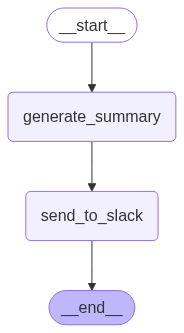

In [24]:
class QuestionSummarizationState(TypedDict):
    cleaned_logs: List[Log]
    report: str
    qs_summary: str
    processed_logs: List[str]

class QuestionSummarizationOutputState(TypedDict):
    report: str
    processed_logs: List[str]


def generate_summary(state):
    cleaned_logs = state["cleaned_logs"]
    summary = "Questions focused on usage of ChatOllama and Chroma vector store."
    return {"qs_summary": summary, "processed_logs": [f"summary-on-log-{log['id']}" for log in cleaned_logs]}

def send_to_slack(state):
    report = "foo bar baz"
    return {"report": report}


qs_builder = StateGraph(QuestionSummarizationState, output = QuestionSummarizationOutputState)
qs_builder.add_node("generate_summary", generate_summary)
qs_builder.add_node("send_to_slack", send_to_slack)

qs_builder.set_entry_point("generate_summary")
qs_builder.add_edge("generate_summary", "send_to_slack")
qs_builder.set_finish_point("send_to_slack")


graph = qs_builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

### **Adding sub graphs to our parent graph**

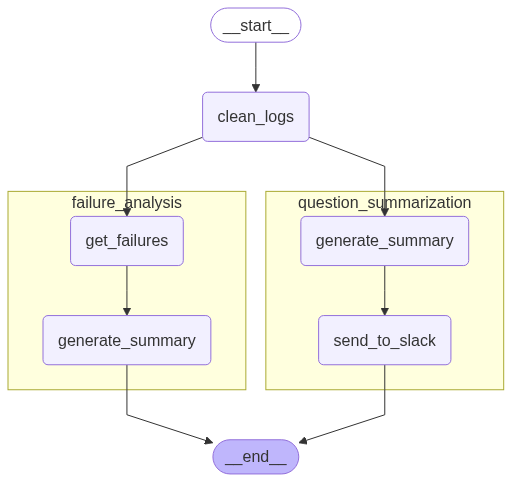

In [39]:
# Entry Graph
class EntryGraphState(TypedDict):
    raw_logs: List[Log]
    cleaned_logs: List[Log]
    fa_summary: str # This will only be generated in the FA sub-graph
    report: str     # This will only be generated in the QS sub-graph
    processed_logs: Annotated[List[int], operator.add] # This will be generated in BOTH sub-graphs
    

def clean_logs(state):
    raw_logs = state["raw_logs"]
    cleaned_logs = raw_logs
    return {"cleaned_logs": cleaned_logs}


entry_builder = StateGraph(EntryGraphState)
entry_builder.add_node("clean_logs", clean_logs)
entry_builder.add_node("question_summarization", qs_builder.compile())
entry_builder.add_node("failure_analysis", fa_builder.compile())

entry_builder.set_entry_point("clean_logs")
entry_builder.add_edge("clean_logs", "failure_analysis")
entry_builder.add_edge("clean_logs", "question_summarization")
entry_builder.set_finish_point("failure_analysis")
entry_builder.set_finish_point("question_summarization")


graph = entry_builder.compile()
display(Image(graph.get_graph(xray = True).draw_mermaid_png()))

In [40]:
# Dummy logs
question_answer = Log(
    id = "1",
    question = "How can I import ChatOllama?",
    answer = "To import ChatOllama, use: 'from langchain_community.chat_models import ChatOllama.'",
)

question_answer_feedback = Log(
    id = "2",
    question = "How can I use Chroma vector store?",
    answer = "To use Chroma, define: rag_chain = create_retrieval_chain(retriever, question_answer_chain).",
    grade = 0,
    grader = "Document Relevance Recall",
    feedback = "The retrieved documents discuss vector stores in general, but not Chroma specifically",
)

raw_logs = [question_answer, question_answer_feedback]
graph.invoke({"raw_logs": raw_logs})

{'raw_logs': [{'id': '1',
   'question': 'How can I import ChatOllama?',
   'answer': "To import ChatOllama, use: 'from langchain_community.chat_models import ChatOllama.'"},
  {'id': '2',
   'question': 'How can I use Chroma vector store?',
   'answer': 'To use Chroma, define: rag_chain = create_retrieval_chain(retriever, question_answer_chain).',
   'grade': 0,
   'grader': 'Document Relevance Recall',
   'feedback': 'The retrieved documents discuss vector stores in general, but not Chroma specifically'}],
 'cleaned_logs': [{'id': '1',
   'question': 'How can I import ChatOllama?',
   'answer': "To import ChatOllama, use: 'from langchain_community.chat_models import ChatOllama.'"},
  {'id': '2',
   'question': 'How can I use Chroma vector store?',
   'answer': 'To use Chroma, define: rag_chain = create_retrieval_chain(retriever, question_answer_chain).',
   'grade': 0,
   'grader': 'Document Relevance Recall',
   'feedback': 'The retrieved documents discuss vector stores in general, 

## **Map-reduce**

In [60]:
import warnings
warnings.filterwarnings("ignore")

from dotenv import load_dotenv, find_dotenv
from langchain_openai import ChatOpenAI

_ = load_dotenv(find_dotenv())
chat = ChatOpenAI(model = 'gpt-3.5-turbo', temperature = 0)

from pydantic import BaseModel
from typing import TypedDict, Annotated
import operator
from langgraph.constants import Send
from langgraph.graph import StateGraph
from IPython.display import display, Image

### **Problem**
Map-reduce operations are essential for efficient task decomposition and parallel processing. 

It has two phases:

1. `Map` - Break a task into smaller sub-tasks, processing each sub-task in parallel.
2. `Reduce` - Aggregate the results across all of the completed, parallelized sub-tasks.

In [61]:
subjects_prompt = """Generate a list of 3 sub-topics that are all related to this overall topic: {topic}."""
joke_prompt = """Generate a joke about {subsubject}"""
best_joke_prompt = """Below are a bunch of jokes about {topic}. Select the best one! Return the ID of the best one, starting 0 as the ID for the first joke. Jokes: \n\n  {jokes}"""

### **State**
#### **Parallelizing joke generation**

In [62]:
class Subjects(BaseModel):
    subjects: list[str]

class BestJoke(BaseModel):
    id: int
    
class OverallState(TypedDict):
    topic: str
    subjects: list
    jokes: Annotated[list, operator.add]
    best_selected_joke: str

In [63]:
def generate_topics(state: OverallState):
    prompt = subjects_prompt.format(topic = state["topic"])

    chain = chat.with_structured_output(Subjects)
    response = chain.invoke(prompt)
    
    return {"subjects": response.subjects}

[Send](https://langchain-ai.github.io/langgraph/concepts/low_level/#send) automatically parallelize joke generation for any number of subjects.
- `generate_joke`: the name of the node in the graph
- `{"subject": s}`: the state to send

`Send` allow you to pass any state that you want to `generate_joke`! It does not have to align with `OverallState`.

In this case, `generate_joke` is using its own internal state, and we can populate this via `Send`.

In [64]:
def continue_to_jokes(state: OverallState):
    return [Send("generate_joke", {"subject": s}) for s in state["subjects"]]

### **Joke generation (map)**

In [65]:
class JokeState(TypedDict):
    subject: str

class Joke(BaseModel):
    joke: str

def generate_joke(state: JokeState):
    prompt = joke_prompt.format(subsubject = state["subject"])

    chain = chat.with_structured_output(Joke)
    response = chain.invoke(prompt)
    
    return {"jokes": [response.joke]}

### **Best joke selection (reduce)**

In [66]:
def best_joke(state: OverallState):
    jokes = "\n\n".join(state["jokes"])
    prompt = best_joke_prompt.format(topic = state["topic"], jokes = jokes)

    chain = chat.with_structured_output(BestJoke)
    response = chain.invoke(prompt)

    return {"best_selected_joke": state["jokes"][response.id]}

### **Compile**

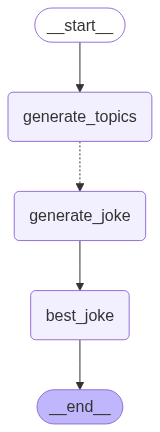

In [67]:
builder = StateGraph(OverallState)
builder.add_node("generate_topics", generate_topics)
builder.add_node("generate_joke", generate_joke)
builder.add_node("best_joke", best_joke)

builder.set_entry_point("generate_topics")
builder.add_conditional_edges(
    "generate_topics", 
    continue_to_jokes, 
    ["generate_joke"]
)
builder.add_edge("generate_joke", "best_joke")
builder.set_finish_point("best_joke")


graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [68]:
for event in graph.stream({"topic": "animals"}): # By default, stream_mode is update
    print(event)

{'generate_topics': {'subjects': ['Mammals', 'Birds', 'Reptiles']}}
{'generate_joke': {'jokes': ['Why did the mammal go to the hospital? Because it had a bad case of hiber-knees!']}}
{'generate_joke': {'jokes': ["Why do birds fly south in the winter? Because it's too far to walk!"]}}
{'generate_joke': {'jokes': ['Why did the reptile bring a ladder to the party? Because he heard the drinks were on the house!']}}
{'best_joke': {'best_selected_joke': 'Why did the mammal go to the hospital? Because it had a bad case of hiber-knees!'}}


## **Research Assistant**

In [38]:
import warnings
warnings.filterwarnings("ignore")


from dotenv import load_dotenv, find_dotenv
from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.document_loaders import WikipediaLoader

_ = load_dotenv(find_dotenv())
chat = ChatOpenAI(model = 'gpt-3.5-turbo', temperature = 0)


from pydantic import BaseModel, Field
from typing import List, TypedDict, Annotated
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage, AnyMessage
from langgraph.graph.message import add_messages
import operator


from langchain_core.messages import get_buffer_string
from langgraph.constants import Send


from langgraph.graph import StateGraph, END
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import display, Image, Markdown

### **Generate Analysts: Human-In-The-Loop**

In [15]:
class Analyst(BaseModel):
    name: str = Field(description = "Name of the analyst.")
    role: str = Field(description = "Role of the analyst in the context of the topic.")
    affiliation: str = Field(description = "Primary affiliation of the analyst.")
    description: str = Field(description="Description of the analyst focus, concerns, and motives.")
    
    def persona(self) -> str:
        return f"Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}\nDescription: {self.description}\n"

class Perspectives(BaseModel):
    analysts: List[Analyst] = Field(description = "Comprehensive list of analysts with their roles and affiliations.")

class GenerateAnalystsState(TypedDict):
    topic: str                   # Research topic
    max_analysts: int            # Number of analysts
    human_analyst_feedback: str  # Human feedback
    analysts: List[Analyst]      # Analyst asking questions

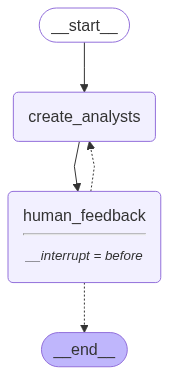

In [16]:
analyst_instructions = """
You are tasked with creating a set of AI analyst personas. Follow these instructions carefully:
1. First, review the research topic: {topic}
2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts: {human_analyst_feedback}
3. Determine the most interesting themes based upon documents and / or feedback above.
4. Pick the top {max_analysts} themes.
5. Assign one analyst to each theme.
"""


def create_analysts(state: GenerateAnalystsState):
    topic = state['topic']
    max_analysts = state['max_analysts']
    human_analyst_feedback = state.get('human_analyst_feedback', '')

    message = analyst_instructions.format(
                    topic = topic,
                    human_analyst_feedback = human_analyst_feedback, 
                    max_analysts = max_analysts
                )
    
    chain = chat.with_structured_output(Perspectives)
    analysts = chain.invoke([
                    SystemMessage(content = message),
                    HumanMessage(content = "Generate the set of analysts.")
                ])
    
    return {"analysts": analysts.analysts}

def human_feedback(state: GenerateAnalystsState):
    """
        No-op node that should be interrupted on 
    """
    pass

def should_continue(state: GenerateAnalystsState):
    """ 
        Return the next node to execute 
    """
    human_analyst_feedback = state.get('human_analyst_feedback', None)
    return "create_analysts" if human_analyst_feedback else END


builder = StateGraph(GenerateAnalystsState)
builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedback)

builder.set_entry_point("create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges(
    "human_feedback", 
    should_continue, 
    ["create_analysts", END]
)


memory = MemorySaver()
graph = builder.compile(interrupt_before = ['human_feedback'], checkpointer = memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [17]:
max_analysts = 3 
topic = "The benefits of adopting LangGraph as an agent framework"
thread = {"configurable": {"thread_id": "1"}}

for event in graph.stream({"topic": topic, "max_analysts": max_analysts}, thread, stream_mode = "values"):
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  

Name: Sophia Watson
Affiliation: Tech Research Institute
Role: AI Research Scientist
Description: Sophia is a seasoned AI research scientist with a focus on agent frameworks. She is interested in the technical aspects of LangGraph and its potential applications in AI systems.
--------------------------------------------------
Name: Ethan Chen
Affiliation: Data Analytics Solutions
Role: Data Analyst
Description: Ethan is a data analyst with a keen interest in the practical implications of adopting LangGraph as an agent framework. He focuses on the benefits of using LangGraph for data analysis and visualization.
--------------------------------------------------
Name: Ava Patel
Affiliation: Ethical AI Foundation
Role: AI Ethics Researcher
Description: Ava is an AI ethics researcher who examines the ethical considerations of using LangGraph as an agent framework. She is concerned with the implications of bias and fairness in AI systems.
--------------------------------------------------


In [18]:
graph.update_state(
    thread, 
    {"human_analyst_feedback": "Add in someone from a startup to add an entrepreneur perspective"}, 
    as_node = "human_feedback"
)

for event in graph.stream(None, thread, stream_mode = "values"):
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50) 

Name: Sophia Watson
Affiliation: Tech Research Institute
Role: AI Research Scientist
Description: Sophia is a seasoned AI research scientist with a focus on agent frameworks. She is interested in the technical aspects of LangGraph and its potential applications in AI systems.
--------------------------------------------------
Name: Ethan Chen
Affiliation: Data Analytics Solutions
Role: Data Analyst
Description: Ethan is a data analyst with a keen interest in the practical implications of adopting LangGraph as an agent framework. He focuses on the benefits of using LangGraph for data analysis and visualization.
--------------------------------------------------
Name: Ava Patel
Affiliation: Ethical AI Foundation
Role: AI Ethics Researcher
Description: Ava is an AI ethics researcher who examines the ethical considerations of using LangGraph as an agent framework. She is concerned with the implications of bias and fairness in AI systems.
--------------------------------------------------
N

In [19]:
graph.update_state(
    thread, 
    {"human_analyst_feedback": None}, 
    as_node = "human_feedback"
)

for event in graph.stream(None, thread, stream_mode = "updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

In [20]:
final_state = graph.get_state(thread)
final_state.next

()

In [21]:
analysts = final_state.values.get('analysts')
for analyst in analysts:
    print(f"Name: {analyst.name}")
    print(f"Affiliation: {analyst.affiliation}")
    print(f"Role: {analyst.role}")
    print(f"Description: {analyst.description}")
    print("-" * 50) 

Name: Sophia Chen
Affiliation: Stanford University
Role: AI Researcher
Description: Sophia is a leading AI researcher at Stanford University, specializing in agent frameworks and their applications in various domains. She is particularly interested in the technical aspects of LangGraph and its potential impact on AI development.
--------------------------------------------------
Name: David Kim
Affiliation: Google Research
Role: Data Scientist
Description: David is a data scientist at Google Research with a focus on natural language processing and machine learning. He is intrigued by the benefits of adopting LangGraph as an agent framework and its implications for enhancing AI capabilities.
--------------------------------------------------
Name: Emily Patel
Affiliation: TechBloom
Role: Startup Founder
Description: Emily is the founder of a tech startup, TechBloom, which focuses on AI solutions for businesses. She is keen on exploring LangGraph as an agent framework from an entrepreneu

### **Conduct Interview**
#### **Generate Question**

In [22]:
class InterviewState(TypedDict):
    messages: Annotated[List[AnyMessage], add_messages]
    max_num_turns: int                     # Number turns of conversation
    context: Annotated[list, operator.add] # Source docs
    analyst: Analyst                       # Analyst asking questions
    interview: str                         # Interview transcript
    sections: list                         # Final key we duplicate in outer state for Send() API

class SearchQuery(BaseModel):
    search_query: str = Field(None, description = "Search query for retrieval.")

In [23]:
question_instructions = """
You are an analyst tasked with interviewing an expert to learn about a specific topic. 
Your goal is boil down to interesting and specific insights related to your topic.

1. Interesting: Insights that people will find surprising or non-obvious.        
2. Specific: Insights that avoid generalities and include specific examples from the expert.

Here is your topic of focus and set of goals: {goals}
    
Begin by introducing yourself using a name that fits your persona, and then ask your question.
Continue to ask questions to drill down and refine your understanding of the topic.
When you are satisfied with your understanding, complete the interview with: "Thank you so much for your help!"
Remember to stay in character throughout your response, reflecting the persona and goals provided to you.
"""


def generate_question(state: InterviewState):
    analyst = state["analyst"]
    messages = state["messages"]

    system_message = question_instructions.format(goals = analyst.persona)
    question = chat.invoke([SystemMessage(content = system_message)] + messages)
        
    return {"messages": [question]}

### **Generate Answer: Parallelization**
We collects information from multiple sources in parallel to answer questions efficiently, such as:
- Specific websites using [`WebBaseLoader`](https://python.langchain.com/v0.2/docs/integrations/document_loaders/web_base/)
- Indexed documents via [RAG](https://python.langchain.com/v0.2/docs/tutorials/rag/)
- Web search (e.g., [Tavily](https://tavily.com/))
- Wikipedia search

In [24]:
tavily_search = TavilySearchResults(max_results = 3)

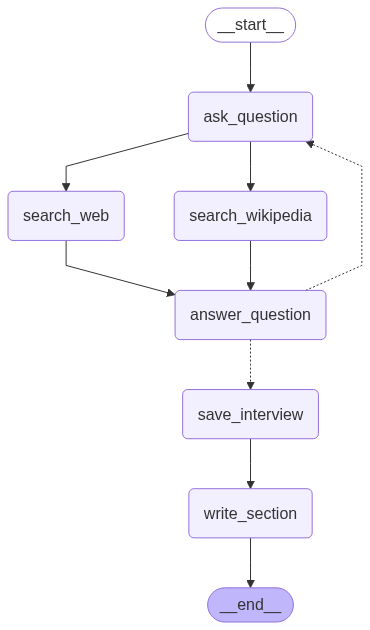

In [25]:
search_instructions = SystemMessage(content = f"""
    You will be given a conversation between an analyst and an expert. 
    Your goal is to generate a well-structured query for use in retrieval and / or web-search related to the conversation.        
    First, analyze the full conversation.
    Pay particular attention to the final question posed by the analyst.
    Convert this final question into a well-structured web search query
""")


def search_web(state: InterviewState):
    chain = chat.with_structured_output(SearchQuery)
    search_query = chain.invoke([search_instructions] + state['messages'])
    
    search_docs = tavily_search.invoke(search_query.search_query)

    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )
    return {"context": [formatted_search_docs]} 

def search_wikipedia(state: InterviewState):
    chain = chat.with_structured_output(SearchQuery)
    search_query = chain.invoke([search_instructions] + state['messages'])
    
    search_docs = WikipediaLoader(
                    query = search_query.search_query, 
                    load_max_docs = 2).load()

    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]
    )
    return {"context": [formatted_search_docs]} 


answer_instructions = """
    You are an expert being interviewed by an analyst.
    Here is analyst area of focus: {goals}.     
    You goal is to answer a question posed by the interviewer.
    To answer question, use this context: {context}

    When answering questions, follow these guidelines:
    1. Use only the information provided in the context. 
    2. Do not introduce external information or make assumptions beyond what is explicitly stated in the context.
    3. The context contain sources at the topic of each individual document.
    4. Include these sources your answer next to any relevant statements. For example, for source # 1 use [1]. 
    5. List your sources in order at the bottom of your answer. [1] Source 1, [2] Source 2, etc
    6. If the source is: <Document source="assistant/docs/llama3_1.pdf" page="7"/>' then just list: 
    [1] assistant/docs/llama3_1.pdf, page 7 
            
    And skip the addition of the brackets as well as the Document source preamble in your citation.
"""


def generate_answer(state: InterviewState):
    analyst = state["analyst"]
    messages = state["messages"]
    context = state["context"]

    system_message = answer_instructions.format(goals = analyst.persona, context = context)
    answer = chat.invoke([SystemMessage(content = system_message)] + messages)
    
    answer.name = "expert"
    return {"messages": [answer]}

def save_interview(state: InterviewState):
    messages = state["messages"]
    interview = get_buffer_string(messages)
    return {"interview": interview}

def route_messages(state: InterviewState, 
                   name: str = "expert"):
    messages = state["messages"]
    max_num_turns = state.get('max_num_turns', 2)

    num_responses = len(
        [m for m in messages if isinstance(m, AIMessage) and m.name == name]
    )
    if num_responses >= max_num_turns:
        return 'save_interview'
    
    last_question = messages[-2]
    if "Thank you so much for your help" in last_question.content:
        return 'save_interview'
    return "ask_question"


section_writer_instructions = """
    You are an expert technical writer.             
    Your task is to create a short, easily digestible section of a report based on a set of source documents.

    1. Analyze the content of the source documents: 
    - The name of each source document is at the start of the document, with the <Document tag.
            
    2. Create a report structure using markdown formatting:
    - Use ## for the section title
    - Use ### for sub-section headers
            
    3. Write the report following this structure:
    a. Title (## header)
    b. Summary (### header)
    c. Sources (### header)

    4. Make your title engaging based upon the focus area of the analyst: {focus}

    5. For the summary section:
    - Set up summary with general background / context related to the focus area of the analyst
    - Emphasize what is novel, interesting, or surprising about insights gathered from the interview
    - Create a numbered list of source documents, as you use them
    - Do not mention the names of interviewers or experts
    - Aim for approximately 400 words maximum
    - Use numbered sources in your report (e.g., [1], [2]) based on information from source documents
            
    6. In the Sources section:
    - Include all sources used in your report
    - Provide full links to relevant websites or specific document paths
    - Separate each source by a newline. Use two spaces at the end of each line to create a newline in Markdown.
    - It will look like:

    ### Sources
    [1] Link or Document name
    [2] Link or Document name

    7. Be sure to combine sources. For example this is not correct:

    [3] https://ai.meta.com/blog/meta-llama-3-1/
    [4] https://ai.meta.com/blog/meta-llama-3-1/

    There should be no redundant sources. It should simply be:

    [3] https://ai.meta.com/blog/meta-llama-3-1/
            
    8. Final review:
    - Ensure the report follows the required structure
    - Include no preamble before the title of the report
    - Check that all guidelines have been followed
"""


def write_section(state: InterviewState):
    context = state["context"]
    analyst = state["analyst"]
   
    system_message = section_writer_instructions.format(focus = analyst.description)
    section = chat.invoke([SystemMessage(content = system_message)] + [HumanMessage(content = f"Use this source to write your section: {context}")]) 
                
    return {"sections": [section.content]}


interview_builder = StateGraph(InterviewState)
interview_builder.add_node("ask_question", generate_question)
interview_builder.add_node("search_web", search_web)
interview_builder.add_node("search_wikipedia", search_wikipedia)
interview_builder.add_node("answer_question", generate_answer)
interview_builder.add_node("save_interview", save_interview)
interview_builder.add_node("write_section", write_section)

interview_builder.set_entry_point("ask_question")
interview_builder.add_edge("ask_question", "search_web")
interview_builder.add_edge("ask_question", "search_wikipedia")
interview_builder.add_edge("search_web", "answer_question")
interview_builder.add_edge("search_wikipedia", "answer_question")
interview_builder.add_conditional_edges(
    "answer_question", 
    route_messages,
    ['ask_question','save_interview']
)
interview_builder.add_edge("save_interview", "write_section")
interview_builder.set_finish_point("write_section")


memory = MemorySaver()
# .with_config is used to attach metadata or runtime configuration to the compiled graph run
interview_graph = interview_builder.compile(checkpointer = memory).with_config(run_name = "Conduct Interviews")
display(Image(interview_graph.get_graph().draw_mermaid_png()))

In [28]:
print (len(analysts), '\n' * 2, analysts[0])

3 

 name='Sophia Chen' role='AI Researcher' affiliation='Stanford University' description='Sophia is a leading AI researcher at Stanford University, specializing in agent frameworks and their applications in various domains. She is particularly interested in the technical aspects of LangGraph and its potential impact on AI development.'


In [ ]:
messages = [HumanMessage(f"So you said you were writing an article on {topic}?")]
interview = interview_graph.invoke({"analyst": analysts[0], "messages": messages, "max_num_turns": 2}, thread)
Markdown(interview['sections'][0])

## LangGraph: Revolutionizing AI Agent Frameworks

### Summary
LangGraph is a cutting-edge framework that is transforming the landscape of AI agent development. This innovative framework offers explicit support for cyclical workflows, a feature crucial for implementing agent-like behaviors. Unlike traditional frameworks, LangGraph does not follow a Directed Acyclic Graph (DAG) model, allowing for cycles that are essential for developing sophisticated agents capable of iterative refinement. This capability enables the creation of advanced AI agents that continuously enhance their understanding and actions, leading to more capable AI systems [1].

LangGraph's state management capabilities ensure the maintenance of conversational context across interactions, while its conditional logic empowers agents to handle diverse user inputs effectively. These features make LangGraph particularly valuable for developing virtual assistants, customer service bots, or educational agents that engage in extended, meaningful dialogues [1].

Moreover, LangGraph excels in multi-agent systems, enabling developers to construct complex agent ecosystems where multiple specialized agents collaborate on intricate tasks. By addressing the limitations of previous AI agent frameworks and offering enhanced flexibility, better state management, and support for cyclic execution and multi-agent systems, LangGraph is poised to significantly impact the future of artificial intelligence [2].

For organizations and developers aiming to build complex agent systems or applications requiring stateful, iterative processing, LangGraph provides a robust foundation that can streamline development processes and enhance system quality. However, it is essential for those working on simpler applications to evaluate whether the additional complexity introduced by LangGraph aligns with their specific requirements and use cases [1].

### Sources
[1] https://medium.com/@ken_lin/langgraph-a-framework-for-building-stateful-multi-agent-llm-applications-a51d5eb68d03  
[2] https://www.analyticsvidhya.com/blog/2024/07/langgraph-revolutionizing-ai-agent/

### **Parallelze interviews: Map-Reduce**

We parallelize the interviews via the `Send()` API, a map step.

We combine them into the report body in a reduce step.

### **Finalize**

We add a final step to write an intro and conclusion to the final report.

In [39]:
class ResearchGraphState(TypedDict):
    topic: str # Research topic
    max_analysts: int # Number of analysts
    human_analyst_feedback: str # Human feedback
    analysts: List[Analyst] # Analyst asking questions
    sections: Annotated[list, operator.add] # Send() API key
    introduction: str # Introduction for the final report
    content: str # Content for the final report
    conclusion: str # Conclusion for the final report
    final_report: str # Final report

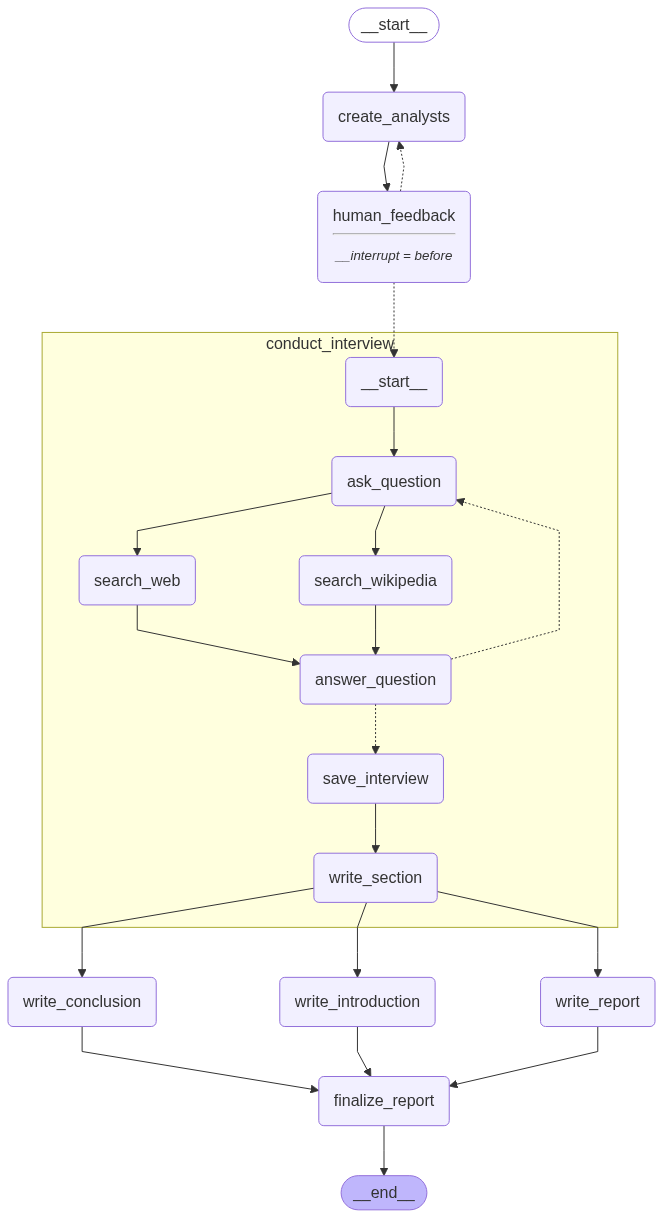

In [ ]:
def initiate_all_interviews(state: ResearchGraphState):
    """ 
        This is the "map" step where we run each interview sub-graph using Send API 
    """    

    human_analyst_feedback = state.get('human_analyst_feedback')
    if human_analyst_feedback:
        return "create_analysts"
    else:
        topic = state["topic"]
        return [Send(
                    "conduct_interview", {
                        "analyst": analyst,
                        "messages": [
                            HumanMessage(content = f"So you said you were writing an article on {topic}?")
                        ]
                    }
                ) for analyst in state["analysts"]]


report_writer_instructions = """
You are a technical writer creating a report on this overall topic: {topic}
You have a team of analysts. Each analyst has done two things: 

1. They conducted an interview with an expert on a specific sub-topic.
2. They write up their finding into a memo.

Your task: 

1. You will be given a collection of memos from your analysts.
2. Think carefully about the insights from each memo.
3. Consolidate these into a crisp overall summary that ties together the central ideas from all of the memos. 
4. Summarize the central points in each memo into a cohesive single narrative.

To format your report:
 
1. Use markdown formatting. 
2. Include no pre-amble for the report.
3. Use no sub-heading. 
4. Start your report with a single title header: ## Insights
5. Do not mention any analyst names in your report.
6. Preserve any citations in the memos, which will be annotated in brackets, for example [1] or [2].
7. Create a final, consolidated list of sources and add to a Sources section with the `## Sources` header.
8. List your sources in order and do not repeat.

[1] Source 1
[2] Source 2

Here are the memos from your analysts to build your report from: {context}
"""


def write_report(state: ResearchGraphState):
    sections = state["sections"]
    topic = state["topic"]

    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    system_message = report_writer_instructions.format(topic = topic, context = formatted_str_sections)    
    report = chat.invoke([SystemMessage(content = system_message)] + [HumanMessage(content = f"Write a report based upon these memos.")]) 
    return {"content": report.content}


intro_conclusion_instructions = """
You are a technical writer finishing a report on {topic}
You will be given all of the sections of the report.
You job is to write a crisp and compelling introduction or conclusion section.
The user will instruct you whether to write the introduction or conclusion.
Include no pre-amble for either section.
Target around 100 words, crisply previewing (for introduction) or recapping (for conclusion) all of the sections of the report.

Use markdown formatting. 
For your introduction, create a compelling title and use the # header for the title.
For your introduction, use ## Introduction as the section header. 
For your conclusion, use ## Conclusion as the section header.

Here are the sections to reflect on for writing: {formatted_str_sections}
"""


def write_introduction(state: ResearchGraphState):
    sections = state["sections"]
    topic = state["topic"]

    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    instructions = intro_conclusion_instructions.format(topic = topic, formatted_str_sections = formatted_str_sections)    
    intro = chat.invoke([instructions] + [HumanMessage(content = f"Write the report introduction")]) 
    return {"introduction": intro.content}

def write_conclusion(state: ResearchGraphState):
    sections = state["sections"]
    topic = state["topic"]

    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    instructions = intro_conclusion_instructions.format(topic = topic, formatted_str_sections = formatted_str_sections)    
    conclusion = chat.invoke([instructions] + [HumanMessage(content = f"Write the report conclusion")]) 
    return {"conclusion": conclusion.content}

def finalize_report(state: ResearchGraphState):
    """ 
        The is the "reduce" step where we gather all the sections, combine them, and reflect on them to write the intro/conclusion 
    """

    content = state["content"]
    if content.startswith("## Insights"):
        content = content.strip("## Insights")
    if "## Sources" in content:
        try:
            content, sources = content.split("\n## Sources\n")
        except:
            sources = None
    else:
        sources = None

    final_report = state["introduction"] + "\n\n---\n\n" + content + "\n\n---\n\n" + state["conclusion"]
    if sources is not None:
        final_report += "\n\n## Sources\n" + sources
    return {"final_report": final_report}


builder = StateGraph(ResearchGraphState)
builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedback)
builder.add_node("conduct_interview", interview_builder.compile())
builder.add_node("write_report", write_report)
builder.add_node("write_introduction",write_introduction)
builder.add_node("write_conclusion",write_conclusion)
builder.add_node("finalize_report",finalize_report)

builder.set_entry_point("create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges("human_feedback", initiate_all_interviews, ["create_analysts", "conduct_interview"])
builder.add_edge("conduct_interview", "write_report")
builder.add_edge("conduct_interview", "write_introduction")
builder.add_edge("conduct_interview", "write_conclusion")
builder.add_edge(["write_conclusion", "write_report", "write_introduction"], "finalize_report")
builder.set_finish_point("finalize_report")


memory = MemorySaver()
graph = builder.compile(interrupt_before = ['human_feedback'], checkpointer = memory)
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [41]:
for event in graph.stream(
        {"topic":topic, "max_analysts":max_analysts}, 
        thread, 
        stream_mode = "values"):
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  

Name: Luna Watson
Affiliation: Tech Research Institute
Role: AI Research Scientist
Description: Luna is passionate about exploring the potential benefits of LangGraph as an agent framework. She focuses on the technical aspects of AI and is interested in how LangGraph can enhance agent capabilities.
--------------------------------------------------
Name: Ethan Chen
Affiliation: Data Analytics Solutions
Role: Data Analyst
Description: Ethan specializes in analyzing data related to agent frameworks. He is particularly interested in the practical applications of LangGraph and how it can improve efficiency in data analysis processes.
--------------------------------------------------
Name: Ava Patel
Affiliation: Ethical AI Foundation
Role: AI Ethics Researcher
Description: Ava's research focuses on the ethical implications of AI technologies. She is interested in studying how LangGraph as an agent framework aligns with ethical principles and promotes responsible AI development.
-----------

In [42]:
graph.update_state(
    thread, 
    {"human_analyst_feedback": "Add in the CEO of gen ai native startup"}, 
    as_node="human_feedback"
)

for event in graph.stream(None, thread, stream_mode = "values"):
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  

Name: Luna Watson
Affiliation: Tech Research Institute
Role: AI Research Scientist
Description: Luna is passionate about exploring the potential benefits of LangGraph as an agent framework. She focuses on the technical aspects of AI and is interested in how LangGraph can enhance agent capabilities.
--------------------------------------------------
Name: Ethan Chen
Affiliation: Data Analytics Solutions
Role: Data Analyst
Description: Ethan specializes in analyzing data related to agent frameworks. He is particularly interested in the practical applications of LangGraph and how it can improve efficiency in data analysis processes.
--------------------------------------------------
Name: Ava Patel
Affiliation: Ethical AI Foundation
Role: AI Ethics Researcher
Description: Ava's research focuses on the ethical implications of AI technologies. She is interested in studying how LangGraph as an agent framework aligns with ethical principles and promotes responsible AI development.
-----------

In [43]:
graph.update_state(
    thread, 
    {"human_analyst_feedback": None}, 
    as_node = "human_feedback"
)

for event in graph.stream(None, thread, stream_mode = "updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

--Node--
conduct_interview
--Node--
conduct_interview
--Node--
conduct_interview
--Node--
write_conclusion
--Node--
write_introduction
--Node--
write_report
--Node--
finalize_report


In [44]:
final_state = graph.get_state(thread)
report = final_state.values.get('final_report')
Markdown(report)

# Unleashing the Power of LangGraph in Agent Frameworks

## Introduction

In the ever-evolving landscape of Artificial Intelligence (AI) development, the choice of agent framework plays a pivotal role in shaping the efficiency and effectiveness of AI applications. LangGraph emerges as a revolutionary framework that offers explicit support for cyclical workflows, a feature essential for implementing sophisticated agent behaviors. Unlike traditional frameworks, LangGraph's emphasis on cycles enables the development of agents capable of iteratively refining their understanding and actions, ultimately leading to more capable AI systems. This introduction sets the stage for exploring LangGraph's unique capabilities, comprehensive agent monitoring and improvement features, as well as its accessibility and popularity in the realm of AI development.

---



LangGraph, a cutting-edge agent framework, is revolutionizing AI development by offering unique capabilities that set it apart from traditional frameworks. One key feature of LangGraph is its explicit support for cyclical workflows, enabling the creation of advanced agents that continuously improve their performance over time [1]. Unlike Directed Acyclic Graph (DAG) frameworks, LangGraph's ability to support cycles is essential for developing sophisticated agents capable of iterative refinement in understanding and actions, leading to more capable AI systems [1].

The framework's built-in persistence feature further enhances the robustness of agent interactions by facilitating memory and cumulative loop functions, ensuring reliability and effectiveness in agent behavior [1]. LangGraph's state management capabilities maintain conversational context across interactions, making it particularly valuable for constructing virtual assistants, customer service bots, or educational agents engaging in extended dialogues [1].

LangGraph's popularity and accessibility are notable, offering a user-friendly platform with a wealth of example projects and tutorials suitable for developers of all skill levels [1]. By leveraging LangGraph in conjunction with tools like Arize's trace ingestion and LLM-based evaluations, developers can effectively monitor and enhance agent performance, ensuring reliability and effectiveness across various tasks [1].

Furthermore, LangGraph's evolution includes improved visualization tools, performance optimizations, and deeper integration within the LangChain ecosystem, making it a preferred choice for teams working on mission-critical AI systems [4]. The framework's control, predictability, and scalability from prototypes to production highlight its significance in the AI development landscape [4].

Companies adopting LangGraph as an agent framework can maximize their business potential by leveraging its flexibility, low-level structure, and support for cyclical workflows [2]. The framework's customizable nature allows for tailored agent design, offering full control over agent actions with persisted context for long-running workflows [3]. By implementing advanced memory management techniques and integration strategies, LangGraph agents can operate more efficiently and effectively, leading to enhanced performance and capabilities [4].

In conclusion, LangGraph's unique features and benefits make it a valuable addition to the AI ecosystem, empowering developers and organizations to build advanced AI applications efficiently and effectively.


---

## Conclusion

In conclusion, LangGraph emerges as a revolutionary agent framework that offers unparalleled capabilities for AI development. By supporting cyclical workflows and stateful agents, LangGraph enables developers to create sophisticated AI systems that continuously improve their performance over time. The framework's popularity, accessibility, and comprehensive monitoring tools make it a preferred choice for developers of all skill levels.

Moreover, LangGraph's evolution with improved visualization tools, performance optimizations, and integration within the LangChain ecosystem solidifies its position as the go-to framework for mission-critical AI systems. Companies leveraging LangGraph can maximize their business potential by building tailored AI solutions that drive efficiency, user engagement, and ultimately, business success. LangGraph's unique features and benefits make it a valuable addition to the AI ecosystem, empowering organizations to develop advanced AI applications efficiently and effectively.

## Sources
[1] [LangGraph - Arize Blog](https://arize.com/blog/langgraph/)  
[2] [LangGraph - Medium Article](https://medium.com/@ken_lin/langgraph-a-framework-for-building-stateful-multi-agent-llm-applications-a51d5eb68d03)  
[3] [LangGraph - LinkedIn Case Study](https://blog.langchain.com/is-langgraph-used-in-production/)  
[4] [LangGraph - Rapid Innovation Article](https://www.rapidinnovation.io/post/ai-agents-in-langgraph/)